# ProxyStore with Workflow Systems

In this experiment, we use Colmena, a library for steering computation campaigns, and Parsl, a workflow system, to quantify overhead reductions when passing data by proxy.

## Instructions

### Setup

1. Clone and install Colmena
   ```bash
   $ git clone git@github.com:exalearn/colmena.git
   $ cd colmena
   $ git checkout v0.3.4
   $ conda env create --file environment.yml -p $(pwd)/env
   $ conda activate $(pwd)/env
   ```
2. Update funcX.
   ```bash
   $ pip install -U funcx==1.0.4 funcx-endpoint==1.0.4
   ```
3. Change to the `synthetic-data` demo app.
   ```bash
   $ cd demo_apps/synthetic-data
   ```
4. [Optional] Configure a funcX endpoint if you want to use funcX as Colmena's compute provider.
   Note that the endpoint configuration will need to be changed customized for the system, allocations, etc.
   ```bash
   $ funcx-endpoint configure colmena-syn-app
   $ funcx-endpoint start colmena-syn-app
   ```
   If not using funcX, Parsl will be used with a local provider as default.
   Modify the `HighThroughputExecutor` in `synthetic.py` to alter the Parsl configuration.
   For example:
   ```python
   HighThroughputExecutor(
       max_workers_per_node=1,
       address=address_by_hostname(),
       provider=CobaltProvider(
           queue='debug-cache-quad',
           account='CSC249ADCD08',
           launcher=AprunLauncher(overrides="-d 256 --cc depth -j 4"),
           worker_init='''
module load conda
conda activate /home/jgpaul/workspace/colmena/env
           ''',
           nodes_per_block=1,
           init_blocks=0,
           min_blocks=0,
           max_blocks=1,
           cmd_timeout=300,
           walltime='00:60:00',
       ),
   )
   ```
   
### Run

Note: `run.sh` is provided with the synthetic app that runs the commands for you and can be modified.
Here we explicitly define the steps.

1. Start a Redis server on the login node the `synthetic.py` app is run on.
   ```bash
   $ redis-server --port 59465 --protected-mode no &> redis.log & 
   ```
2. Run the app.
   ```bash
   $ python synthetic.py \
         --parsl --local \
         --redis-host localhost --redis-port 59465 \
         --count 5 --input-size 1 --output-size 1 --interval 1 --sleep-time 0 \
         --output-dir runs/
   ```
   The run logs will be save to `runs/{TIMESTAMP}/runtime.log`.
   These logs are parsed for the analysis in this notebook.
3. Kill the Redis server.
   ```bash
   $ jobs  # find the job number. it is likely #1
   $ kill $1
   ```

In [1]:
from __future__ import annotations

import json
import os
import statistics
from typing import Any

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy

In [2]:
BASELINE_FILEPATH = 'data/2-proxystore-with-workflow-systems/baseline.jsonl'
FILESTORE_FILEPATH = 'data/2-proxystore-with-workflow-systems/filestore.jsonl'
REDISSTORE_FILEPATH = 'data/2-proxystore-with-workflow-systems/redisstore.jsonl'

In [3]:
def load(filepath: str) -> list[dict[str, Any]]:
    with open(filepath) as f:
        return [json.loads(line) for line in f.readlines() if line.strip() != '']
    
baseline_data = load(BASELINE_FILEPATH)
filestore_data = load(FILESTORE_FILEPATH)
redisstore_data = load(REDISSTORE_FILEPATH)

In [4]:
def clean_and_flatten(data: list[dict[str, Any]]) -> list[dict[str, Any]]:
    out = []
    for sample in data:
        if sample['success']:
            new = {
                'input_bytes': int(1000000 * sample['task_info']['input_size']),
                'output_bytes': int(1000000 * sample['task_info']['output_size']),
                'rtt': sample['time_result_received'] - sample['time_created'],                
            }
            out.append(new)
    return out

baseline_data_clean = clean_and_flatten(baseline_data)
filestore_data_clean = clean_and_flatten(filestore_data)
redisstore_data_clean = clean_and_flatten(redisstore_data)

In [5]:
def unique_values(data: list[dict[str, Any]], name: str) -> list[Any]:
    return set(sample[name] for sample in data)

def matching(data: list[dict[str, Any]], **kwargs) -> list[dict[str, Any]]:
    out = []
    for sample in data:
        for key, value in kwargs.items():
            if sample[key] != value:
                break
        else:
            out.append(sample)
    return out

def aggregate(data: list[dict[str, Any]]) -> list[dict[str, Any]]:
    input_sizes = sorted(unique_values(data, 'input_bytes'), reverse=True)
    output_sizes = sorted(unique_values(data, 'output_bytes'), reverse=True)
    out = []
    
    for input_size in input_sizes:
        for output_size in output_sizes:
            samples = matching(data, input_bytes=input_size, output_bytes=output_size)
            rtts = [sample['rtt'] for sample in samples]
            new = {
                'input_bytes': input_size,
                'output_bytes': output_size,
                'median_rtt': statistics.median(rtts),
                'mean_rtt': sum(rtts) / len(rtts),
                'min_rtt': min(rtts),
                'max_rtss': max(rtts),
                'std_rtt': statistics.stdev(rtts),
            }
            out.append(new)
    return out

baseline_data_aggregate = aggregate(baseline_data_clean)
filestore_data_aggregate = aggregate(filestore_data_clean)
redisstore_data_aggregate = aggregate(redisstore_data_clean)

In [6]:
def improvement(starting: list[dict[str, float]], final: list[dict[str, float]]) -> list[dict[str, float]]:
    out = []
    for baseline in starting:
        sample = matching(final, input_bytes=baseline['input_bytes'], output_bytes=baseline['output_bytes'])
        assert len(sample) == 1
        sample = sample.pop()
        new = {
            'input_bytes': baseline['input_bytes'],
            'output_bytes': baseline['output_bytes'],
            'median_rtt_improvement_percent': (baseline['median_rtt'] - sample['median_rtt']) / baseline['median_rtt'],
        }
        out.append(new)
    return out

filestore_changes = improvement(baseline_data_aggregate, filestore_data_aggregate)
redisstore_changes = improvement(baseline_data_aggregate, redisstore_data_aggregate)

def matrixify(data: list[dict[str, float]]) -> list[list[float]]:
    x_values = sorted(unique_values(data, 'input_bytes'), reverse=True)
    y_values = sorted(unique_values(data, 'output_bytes'), reverse=False)
    
    rows = []
    for xval in x_values:
        row = []
        for yval in y_values:
            sample = matching(data, input_bytes=xval, output_bytes=yval)
            assert len(sample) == 1
            sample = sample.pop()
            row.append(sample['median_rtt_improvement_percent'])
        rows.append(row)
    return rows

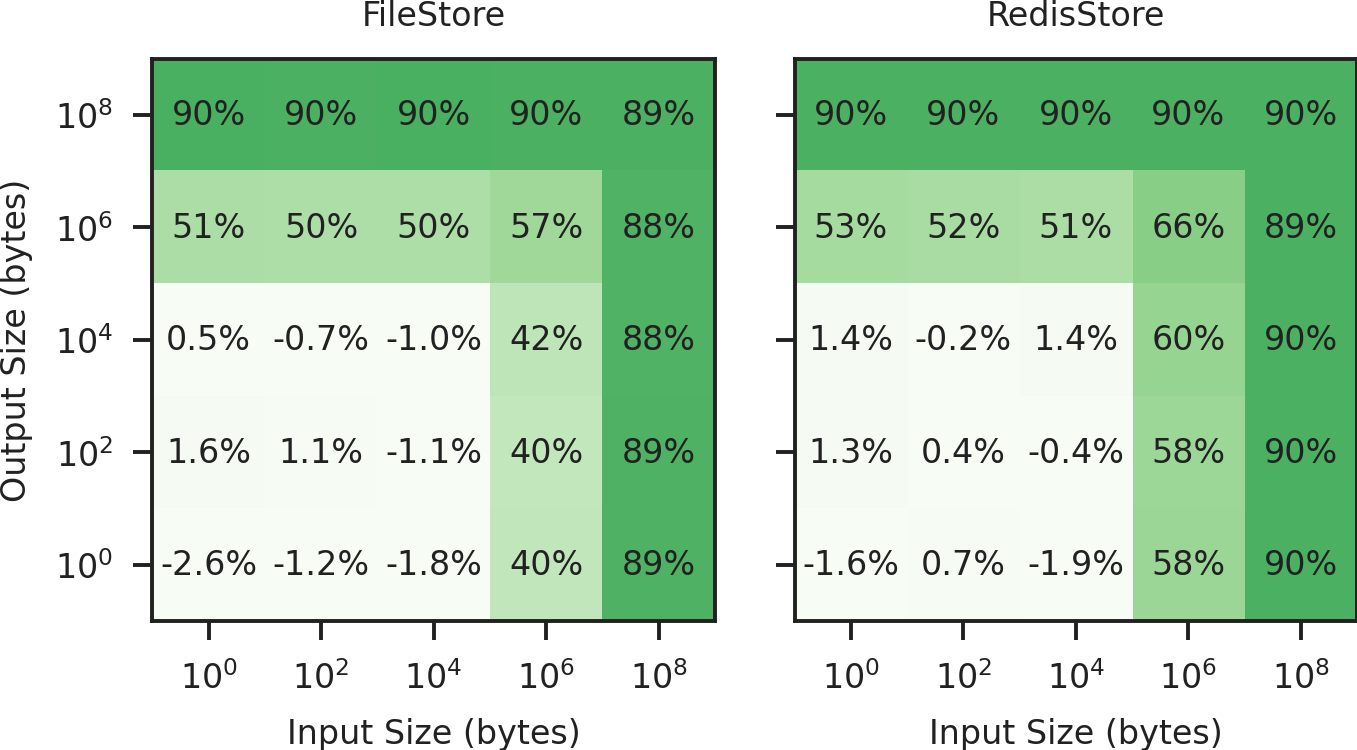

In [13]:
fig, axs = plt.subplots(1, 2, sharey=True)

labels = ['$10^0$', '$10^2$', '$10^4$', '$10^6$', '$10^8$']

for change_data, ax in zip((filestore_changes, redisstore_changes), axs):
    xy = matrixify(change_data)
    caxes = ax.matshow(xy, cmap=matplotlib.cm.Greens, vmin=0, vmax=1.5)
    
    for y, row in enumerate(xy):
        for x, val in enumerate(row):
            val = 100*val
            ax.text(x, y, f'{val:0.0f}%' if val >= 10 or val <= -10 else f'{val:0.1f}%', ha='center', va='center', fontsize=6)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(reversed(labels))

axs[0].set_title('FileStore')
axs[1].set_title('RedisStore')
axs[0].set_xlabel('Input Size (bytes)')
axs[1].set_xlabel('Input Size (bytes)')
axs[0].set_ylabel('Output Size (bytes)')

fig.tight_layout(h_pad=.5, w_pad=0.75)

fig.set_size_inches(3.5, 1.5)
plt.savefig('figures/colmena-overheads.pdf', pad_inches=0.05)